In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
import sys 
sys.path.insert(0,'/Users/graf-m/git/pycomlink')

import pycomlink as pycml
import pycomlink.processing.wet_dry.nearby_wetdry as nearby_wetdry

In [4]:
# Do show xarray.Dataset representation as text because gitlab/github 
# do not (yet) render the html output correctly (or sometimes not at all...)
xr.set_options(display_style='text');

# Example of the rain event detection using the nearby-wetdry appraoch from [Overeem et al. 2016](https://amt.copernicus.org/articles/9/2425/2016/amt-9-2425-2016.pdf)

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [5]:
pycml.io.examples.get_example_data_path()

'/Users/graf-m/git/pycomlink/pycomlink/io/example_data'

In [6]:
data_path = pycml.io.examples.get_example_data_path()

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

#### prepare data
removing default values from CML DAQ system and interpolating small gaps in tsl and rsl time series

In [7]:
cmls["rsl"] = cmls["rsl"].where(cmls.rsl > -99.9)
cmls["tsl"] = cmls["tsl"].where(cmls.tsl < 255.0)
cmls["rsl"] = cmls.rsl.interpolate_na(dim="time", method="linear", max_gap="5min")
cmls["tsl"] = cmls.tsl.interpolate_na(dim="time", method="linear", max_gap="5min")

#### Instanteanous to min-max data
transfering instantaneous example data to 15 minute (interval) min-max data defining the minmal number of hours (min_hours) needed in a given time period (time period) to calssify wet and dry periods in the subsequent step

In [8]:
ds_cml_minmax = nearby_wetdry.instanteanous_to_minmax_data(
    cmls, interval=15, timeperiod=24, min_hours=6
)

#### Calculating distances between all cml endpoints and plotting the neighbors used for wet-dry classification depending on the distance

In [9]:
ds_dist = nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=cmls.cml_id.values,
    site_a_latitude=cmls.site_a_latitude,
    site_a_longitude=cmls.site_a_longitude,
    site_b_latitude=cmls.site_b_latitude,
    site_b_longitude=cmls.site_b_longitude,
)

500it [00:02, 184.14it/s]


In [10]:
r=15
ds_dist["within_r"] = (
        (ds_dist.a_to_all_a < r)
        & (ds_dist.a_to_all_b < r)
        & (ds_dist.b_to_all_a < r)
        & (ds_dist.b_to_all_b < r)
)


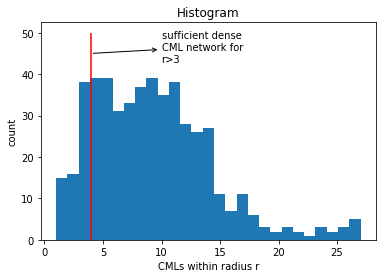

In [11]:
ds_dist.within_r.sum(dim="cml_id2").plot.hist(bins=int(ds_dist.within_r.sum(dim="cml_id2").max()))
plt.vlines(4,ymin=0,ymax=50,color="red")
plt.annotate(text="sufficient dense\nCML network for\nr>3", xy=(4,45), xytext=(10,43), arrowprops=dict(arrowstyle="<-"))
plt.xlabel("CMLs within radius r")
plt.ylabel("count");

#### Actual wet dry classification
using default paramters from Overeem et al. (2016)

In [12]:
ds_cml_minmax["wet"]=nearby_wetdry.nearby_wetdry(
    ds_cml=ds_cml_minmax,
    ds_dist=ds_dist,
    r=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.77it/s]


#### Compare instanteanous and minmax time series 

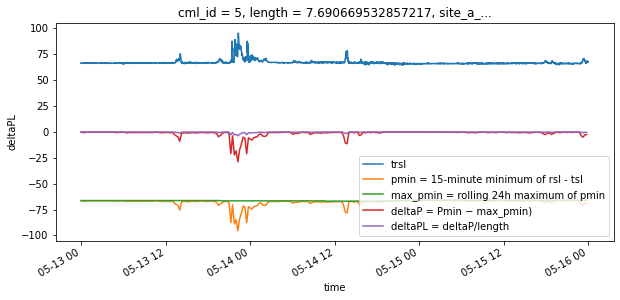

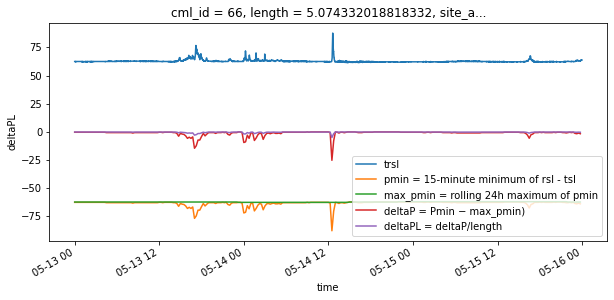

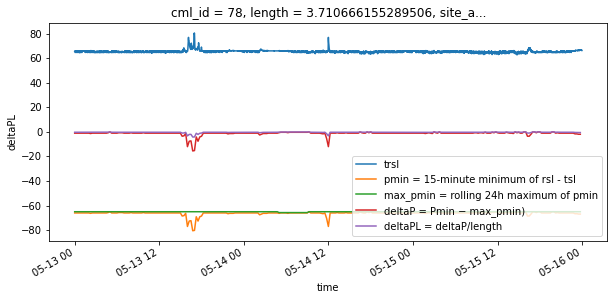

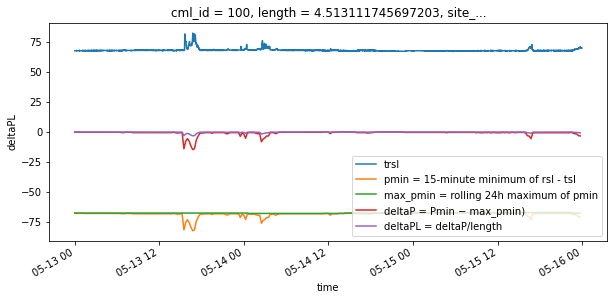

In [13]:
t_start,t_end="2018-05-13","2018-05-15"
for cmlid in ["5","66","78","100"]:
    
    (cmls.sel(cml_id=cmlid).tsl - cmls.sel(cml_id=cmlid).rsl).isel(channel_id=0).sel(time=slice(t_start,t_end)).plot(figsize=(10, 4), label="trsl")
    ds_cml_minmax.sel(cml_id=cmlid,time=slice(t_start,t_end)).isel(channel_id=0).pmin.plot(label="pmin = 15-minute minimum of rsl - tsl")
    ds_cml_minmax.sel(cml_id=cmlid,time=slice(t_start,t_end)).isel(channel_id=0).max_pmin.plot(label="max_pmin = rolling 24h maximum of pmin")
    ds_cml_minmax.sel(cml_id=cmlid,time=slice(t_start,t_end)).isel(channel_id=0).deltaP.plot(label="deltaP = Pmin − max_pmin)")
    ds_cml_minmax.sel(cml_id=cmlid,time=slice(t_start,t_end)).isel(channel_id=0).deltaPL.plot(label="deltaPL = deltaP/length")
    plt.legend()

#### Comparing wet dry classification example time series to a reference
with the possibility to plot deltaP and deltaPL which are used for the classification

In [14]:
ref = xr.open_dataset(data_path + '/example_path_averaged_reference_data.nc')

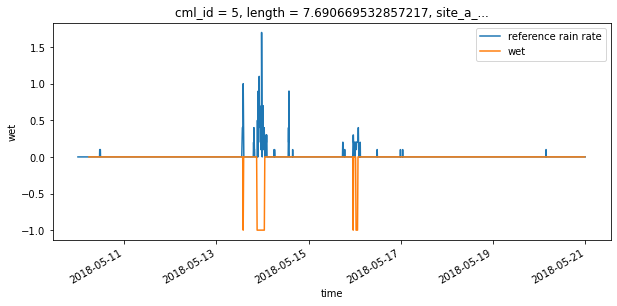

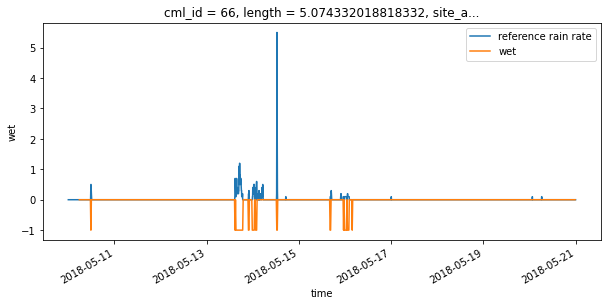

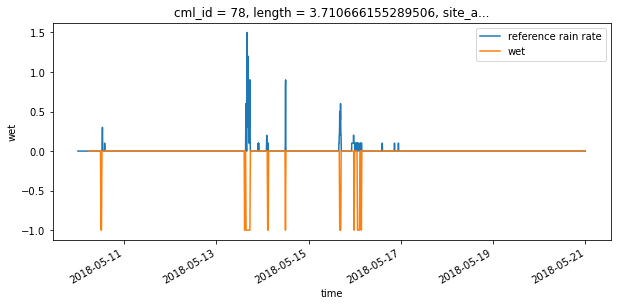

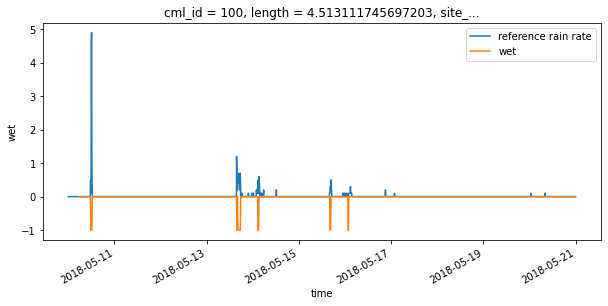

In [15]:
for cmlid in ["5","66","78","100"]:
    fig,ax=plt.subplots(figsize=(10,4))
    ref.sel(cml_id=cmlid).rainfall_amount.plot(ax=ax,label='reference rain rate')
    (ds_cml_minmax.isel(channel_id=0).sel(cml_id=cmlid).wet*-1).plot(ax=ax,label='wet')
    #ds_cml_minmax.isel(channel_id=0).sel(cml_id=cmlid).deltaP.plot(ax=ax,label='deltaP')
    #ds_cml_minmax.isel(channel_id=0).sel(cml_id=cmlid).deltaPL.plot(ax=ax,label='deltaPL')
    plt.legend();
